In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import IsolationForest

## Acerca las librerías no antes usadas.

### XGBoost

El cual es la abreviatura del inglés sXtreme Gradient Boosting, de acuerdo a la documentación del mismo, "es una biblioteca optimizada de aumento de gradiente distribuido diseñada para ser altamente eficiente, flexible y portátil . Implementa algoritmos de aprendizaje automático bajo el marco de Gradient Boosting"[1]

Esta librería utiliza arboles de decisión y técnicas de aprendizaje de refuerzo para mejorar el rendicmiento predictivo y de clasificación, es altamente utilizado en campos como las finanzas y salud.

## Información sobre el Dataset
*Los cardiotocogramas* (CTG) son una manera de evaluar la salud del feto, a través del monitoreo de la frecuencia cardiaca de éste y las contracciones uterinas de la madre, permite el tomar acción y prevenir la mortalidad infantil. Esto, a traves de leer sensores de ultrasonido para conocer el ritmo cardiaco del feto, y un tocógrafo para registrar las contracciones uterinas. [2]


El dataste esta compuesto de 40 variables y 2126 registros extraidos de exámenes de cardiotogramas, que fueron clasificados de dos maneras, una con respecto al patrón morfológico (A, B, C. ...) y de acuerdo al estado fetal (N, S, P):

Cabe mencionar que cuando se mencione "SisPorto", se refiere al sistema y evaluación de registros CTG desarrollado por la Universidad de Oporto en Portugal.

### Variables: Datos numéricos.

Lista de variables (omitidas las primero cinco columnas para este estudio).

- *LBE: valor base Frecuencia Cardiaca (Médico Experto) 
- *LB: valor base Frecuencia Cardiaca (Generado por SisPorto[3])
- *AC: aceleraciones (SisPorto)
- *FM: movimiento fetal (SisPorto)
- *UC: contracciones uterinas (SisPorto)
- *DL: desaceleraciones leves
- *DS: desaceleraciones severas
- *DP: desaceleraciones prolongadas
- *DR: desaceleraciones repetitivas

#### Producto de un pre'análisis por parte de SisPorto

- *ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)
- *mSTV: valor medio de la variabilidad a corto plazo (SisPorto)
- *ALTV: porcentaje de tiempo con variabilidad a largo plazo anormal (SisPorto)
- *mLTV: valor medio de la variabilidad a largo plazo (SisPorto)

#### Números del Histograma

- *Ancho: anchura del histograma
- *Mín: frecuencia baja del histograma
- *Máx: frecuencia alta del histograma
- *Nmax: número de picos del histograma
- *Nzeros: número de ceros del histograma
- *Moda: moda del histograma
- *Media: media del histograma
- *Mediana: mediana del histograma
- *Varianza: varianza del histograma
- *Tendencia: tendencia del histograma: -1=asimétrica a la izquierda; 0=simétrica; 1=asimétrica a la derecha

### Clasificación por Patrón Morfológico de 10 Clases, resumida en la columna CLASS
- A: Patrón de sueño tranquilo
- B: Patrón de sueño REM
- C: vigilia tranquila
- D: vigilia activa
- SH: patrón de cambio (A o Susp con cambios)
- AD: patrón acelerativo/decelerativo (situación de estrés)
- DE: patrón decelerativo (estimulación vagal)
- LD: patrón ampliamente decelerativo
- FS: patrón plano-sinusoidal (estado patológico)
- SUSP: patrón sospechoso
- CLASS: código de clase (de 1 a 10) para las clases de A a SUSP

### Clasificación por Estado del Feto de 3 Clases, resumida en la columna NSP
- NSP: Normal=1; Sospechoso=2; Patológico=3


In [2]:
#utilitario para ignorar Warnings, no tomar en cuenta para el reporte final
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#utilitario para dar formato a las tablas al estilo 'ggplot' de R
plt.style.use('ggplot')

## Análisis Exploratorio de los Datos.

Sin caer en trivialiadades (todos los datos de la tabla son numéricos), haremos una diferención entre ellos de acuerdo a su origen, así, tenemos los datos producto de la Toma de datos de los instrumentos, otros derivados de un cálculo, por ejemplo, un valor promedio, que al provenir de los datos tomados, poseen cierta correlación y por ende podrían inducir a un bias, otros relacionados a lo que parece cierto pre'análsis estadístico a modo de histograma y por último dos tipos de clases. La naturaleza del origen de los datos nos puedan dar indicios acerca de su correlación.

In [4]:
###Se carga la base de datos completa a ser utilizada para el estudio
data = pd.read_csv('CTG.csv')

###Removemos las primeras cinco columnas que poseen la información Administrativa del proceso de estudio.
data = data.drop(columns=['FileName', 'Date', 'SegFile', 'b', 'e'])

###Dejaremos a éste punto el resto de los datos, tener en cuenta lo que se comentó anteriormente en relación aquellos que son producto de la ´Toma de Datos´

data.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [5]:
###Verificamos rápidamente la información general de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   float64
 1   LB        2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   ASTV      2127 non-null   float64
 6   MSTV      2127 non-null   float64
 7   ALTV      2127 non-null   float64
 8   MLTV      2127 non-null   float64
 9   DL        2128 non-null   float64
 10  DS        2128 non-null   float64
 11  DP        2128 non-null   float64
 12  DR        2128 non-null   float64
 13  Width     2126 non-null   float64
 14  Min       2126 non-null   float64
 15  Max       2126 non-null   float64
 16  Nmax      2126 non-null   float64
 17  Nzeros    2126 non-null   float64
 18  Mode      2126 non-null   float64
 19  Mean      2126 non-null   float64
 20  Median    2126 non-null   floa

### Descripción de lo visto

Se notan que el número de filas no es uniforme, en su mayoría es de 2126, pero hay columnas con 2127, 2128.
Es necesario entender a que se debe, veamos el final de la tabla.

In [6]:
## Viendo el fondo de la tabla para identificar posibles datos extra.
data.tail()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,142.0,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,NaN,564.0,23.0,87.0,7.0,91.0,50.7,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por la naturaleza del estudio hay que darse cuenta que hay una diferencia entre datos nulos NaN y ceros, en algunas columnas, en especial la de ´Toma de Datos´, cero, poseen un valor a ser considerado, lo anterior, de nuevo, depende del tipo de dato, podemos apreciar que las filas extra podrían interpretarse como datos faltantes y por ello aparecen como NaN, de ser ese el caso, es mejor eliminarlos.

In [7]:
# Elimina las últimas 3 filas del Dataset
data = data.drop(data.index[-3:])

In [8]:
## Reinspeccionando la tabla.
data.tail()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2121,140.0,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2122,140.0,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2123,140.0,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,142.0,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [9]:
###Confirmamos cuantos valores nulos existen por columna
data.isnull().sum()
#data.isna().sum()

LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [10]:
###Optenemos una descripción General del Dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
LB,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.0,26.0
FM,2126.0,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0
UC,2126.0,3.659925,2.847094,0.0,1.0,3.0,5.0,23.0
ASTV,2126.0,46.990122,17.192814,12.0,32.0,49.0,61.0,87.0
MSTV,2126.0,1.332785,0.883241,0.2,0.7,1.2,1.7,7.0
ALTV,2126.0,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0
MLTV,2126.0,8.187629,5.628247,0.0,4.6,7.4,10.8,50.7
DL,2126.0,1.570085,2.499229,0.0,0.0,0.0,3.0,16.0


A continuación se puede ver la diferencia por dicho detalle, nótese que estamos usando los datos producto del proceso de Toma de Datos, detallado anteriormente, en esa diferencia se nota como se han afectado ciertos valores estadísticos, como lo es en el caso de FM o Movimiento Fetal.

| Datos Originales | Datos SIN NaN |
| ------------ | ------------ |
| ![Original](Imagenes/Original.png) | ![Sin NaN](Imagenes/SinNaN.png) |

Claro está, que esas filas eliminadas son hasta cierto punto obvias, lo cierto es que las tablas en general son tan grandes que una inspección visual es inútil, por ello vamos a seguir estudiando los datos para encontrar mas inconsistencias o anomalías.

Pero, iniciaremos con la obvia, que corresponde a las columnas LBE y LB, ambas corresponden a la Frecuencia Cardiaca del Feto, sólo que una es por parte del médico y la otra por parte del equipo del SisPorto, ambas columnas son mutuamente redundantes, ello se puede notar al ver los datos en la tabla anterior, por lo que se elimnará una de ellas.

De las imágenes anteriores podemos darnos cuenta que a pesar de que los NaN han sido eliminados, hay ciertos valores que dan evidencia de posibles anomalías. ese sigue siendo el caso de FM, si bien su promedio y desviación estándar fueron mejorados al remover los datos extra, todavía apreciamos que, mientras el valor máximo es de 564.0, su promedio es de tan sólo 7.50, de igual manera se podría sospechar de las columnas AC y UC, aunque no parece tan evidente como para FM, por eso aplicaremos técnicas de visualición para terminar de confirmar posibles outliers, y de ser el caso afirmativo, aplicar lo necesario para eliminarlos.

![Posibles Anomalías](Imagenes/outliers001.png)

Por otro lado, es interesante analizar los valores de las columnas de Desaceleraciones en general, DL, DS, DP y DR. Se nota que fuera de datos NaN, la cantidad de valores iguales a cero es tal que afecta las estadísticas, acá también es mejor aplicar técnicas de visualización para terminar de entender sus efectos o si son anomalías a eliminar.

Una razón por la cuál aplicando estadística simple no podemos determinar o concluir con certeza si estamos en la presencia de una anomalía es si la distribución de los datos para esa columna en particular no sigue una distribución normal, por ende, empezaremos por ello, viendo cada uno de los histogramas de los datos.

In [11]:
# Vamos a tener varias tablas para analizar

# La siguiente es para los Datos Tomados
data_tom = data.copy()

data_tom = data_tom.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS','NSP', 'Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

In [12]:
from ipywidgets import interact
#create a histogram

#función paraa mostrar interactivamente los histograma, por conveniencia al ser muchos
def mhist(colm):
    plt.figure(figsize=(5, 3))
    plt.hist(data_tom[colm],bins=10,label=colm)
    #Formatos
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma {colm}')

interact(mhist, colm=data_tom.columns);

interactive(children=(Dropdown(description='colm', options=('LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'AL…

![Histograma_UC](Imagenes/HistogramaUC.png)

Al ver los histogramas confirmamos que LB y LBE son lo mismo, además que es la única columna que sigue una distribución normal.
Para FM se confirma que hay uno o varios outliers los cuales tenemos que identificar puntualmente y arreglar.
Para el resto de las columnas se confirma que debemos usar otras técnicas estadíticas y/o de visualización para datos no normales.

In [13]:
#Los siguientes son las columnas que utilizaremos para analizar cuales poseen outliers que han de ser eliminados

data_2FindOutl = data.copy()

data_2FindOutl = data_2FindOutl.drop(columns=['LB', 'ASTV','MSTV','ALTV','MLTV','A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS','NSP', 'Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

Utilizaremos un Box-Plot, ésta es una de las mejores maneras de rápidamente identificar si los datos poseen anomalías, de encontrarse, en el siguiente apartado se hará lo necesario para elimnarlos.

In [14]:
#Box Plot

import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Función para mostrar un boxplot para una columna dada
def mostrar_boxplot(columna):
    plt.figure(figsize=(8, 6))
    plt.boxplot(data[columna])
    plt.xlabel(columna)
    plt.title(f'Boxplot: {columna}')
    plt.show()

#Para escoger las columnas
columnas = data_2FindOutl.columns

# Utiliza interact para crear un menú desplegable interactivo para seleccionar la columna
interact(mostrar_boxplot, columna=Dropdown(options=columnas));


interactive(children=(Dropdown(description='columna', options=('LBE', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR'…

![BoxPlot_UC](Imagenes/BoxPlotUC.png)

Ahora, después de haber aplicado un análisis estadítico, haber graficado los hitogramas y Box-Plots, es recomendable ahora con certeza, hacer lo necesario para eliminar los datos anómalos del Dataset, sabemos que hay, lo que no tenemos noción en éste momento es de cuales son, pultualmente hablando. Por ende, exploraremos varias técnicas de eliminación de anomalías en el apartado correspondiente. 

## Análisis de variables Categóricas

Al inicio se identificó que la tabla posee dos Clases, una que realiza una clasificación con respecto a patrones morfológicos como A: Patrón de sueño calmo, B: Patrón de sueño REM, que se agrupan en la columna CLASS: Código de Clases (1 a 10) paraa las clases de la A a SUSP. Por otro lado se encuentra la clasificación por estado fetal, que está en la columna NSP y se codifica como: 1 = Normal; 2 = Sospechoso; 3 = Patológico, veamos cómo lucen esos datos.


### Patrones Morfológicos

Clases de la A a la SUSP, las frecuencias se verán reflejadas en la columna CLASS

In [15]:
#Los siguientes son las columnas que utilizaremos para analizar las Categorias existentes

data_Clases = data.copy()

data_Clases = data_Clases.drop(columns=['LBE','LB','AC','FM','UC','ASTV','MSTV','ALTV','MLTV','DL','DS','DP','DR','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

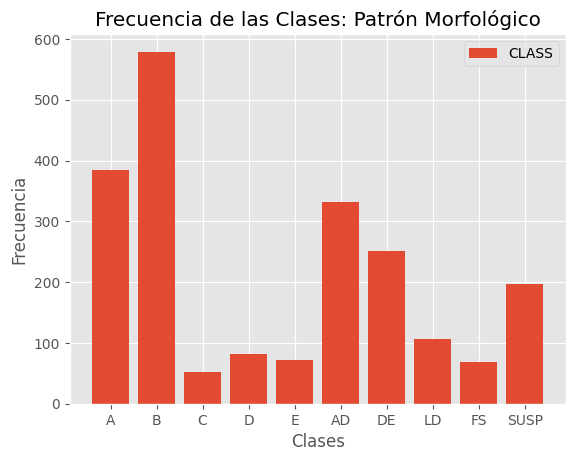

In [16]:
#El siguiente código es para poder observar la distribución de frecuencias de la Categoría

class_frequencies = data['CLASS'].value_counts().sort_index()

# Crear una lista con las etiquetas de las clases
classes = ['A','B','C','D','E','AD','DE','LD','FS','SUSP']
# Crear el gráfico de barras
plt.bar(classes, class_frequencies)

# Agregar etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las Clases: Patrón Morfológico')

# Agregar leyenda con el nombre de la columna
plt.legend(['CLASS'])

# Mostrar el gráfico
plt.show()


Lo que podemos pareciar de la distribución es que las 4 clases predominantes son, por orden de mayor a menor:
- B: Patrón de Sueño REM, , con casi 600 casos.
- A: Patrón de Sueño Calmo, cercano a 400.
- AD: Patrón de situación de Stress, cerca a 350 casos.
- DE: Patrón de Desaceleración (Estimulación del nervio vago), con un poco mas de 250 casos.

La pregunta acá sería, como se relacionan éstas clases con los datos, bueno, tendremos que hacer una matriz de correlación con el fin de poner en evidencia los casos.

Veamos como correlacionan los datos con sólo éstas categorías.

In [17]:
#Iniciamos con algunos estudios para entender como se comportan los datos

data_corr10 = data.copy()

data_corr10 = data_corr10.drop(columns=['LB','ASTV','MSTV','ALTV','MLTV', 'NSP','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])
data_corr10 = data_corr10.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP'])

<Axes: >

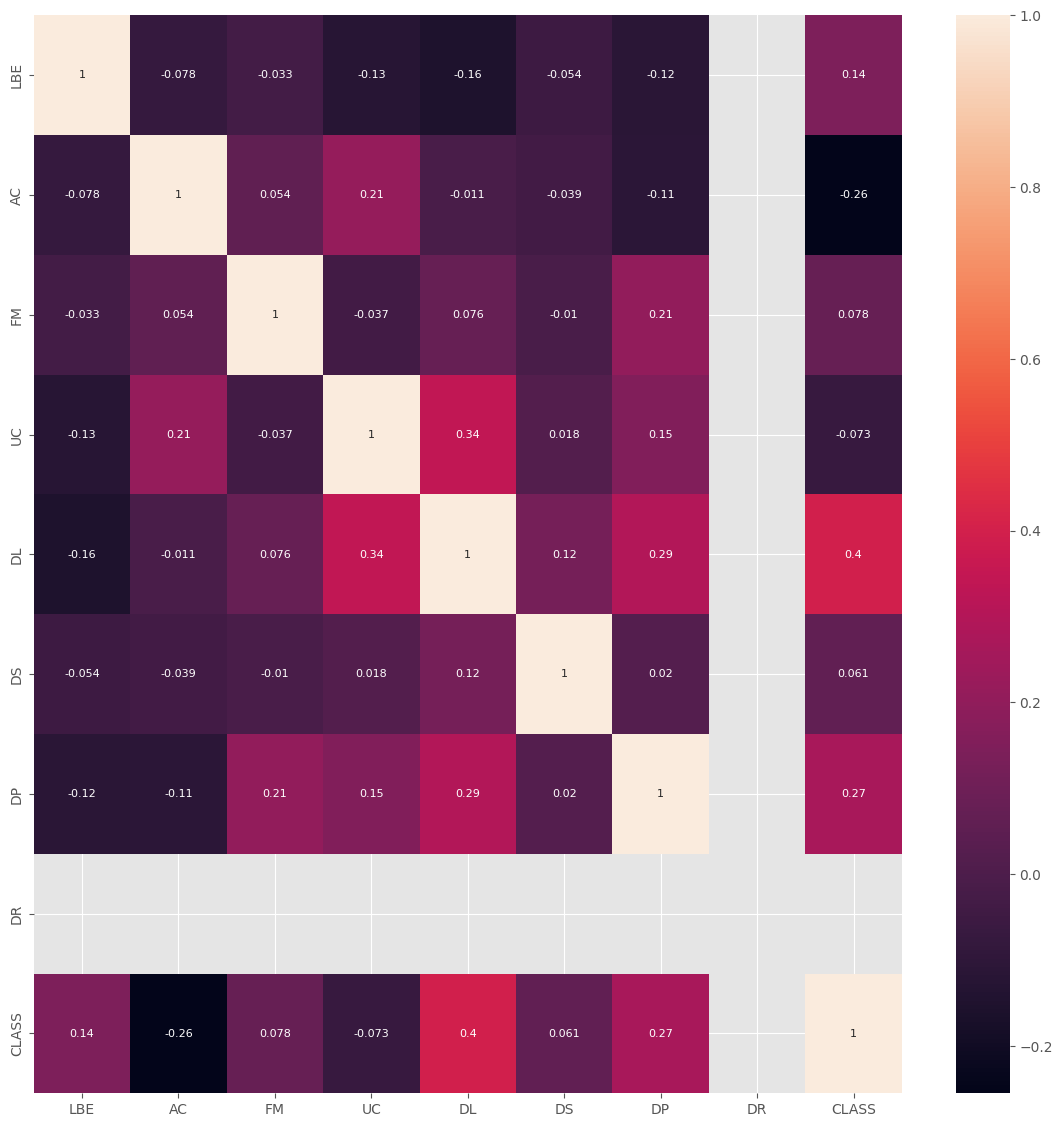

In [18]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data_corr10.corr(), annot=True, annot_kws={"size": 8})

In [19]:
#Como correlaciona con CLASS

data_corr10.corr()['CLASS'].sort_values(ascending=False)

CLASS    1.000000
DL       0.395887
DP       0.269300
LBE      0.143001
FM       0.077805
DS       0.060861
UC      -0.073465
AC      -0.255205
DR            NaN
Name: CLASS, dtype: float64

El Mapa de calor es bastante oscuro, el nivel de correlación entre los datos tomados y las categorías morfológicas, muestra que:

- La variable mas cercana posee un valor de 0.395 que corresponde a las Desaceleraciones Livianas DL.
- Le sigue con 0.269 DP: Desacelereaciones Prolongadas.
- Luego con -0.255 AC: Aceleraciones.
- Y la cuarta sería LBE: Frecuencia Cardiaca con 0.143.

Además DR demuestra no contribuir en lo absoluto al análisis, por lo tanto dejaremos de lado del análisis a las Desaceleraciones Repetitivas.

A continuación, veremos los datos correspondientes al Estado del Feto NSP, detallado anteriormente.

In [20]:
#Iniciamos con algunos estudios para entender como se comportan los datos

data_corr = data.copy()

data_corr = data_corr.drop(columns=['LB','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])
data_corr = data_corr.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP', 'CLASS'])

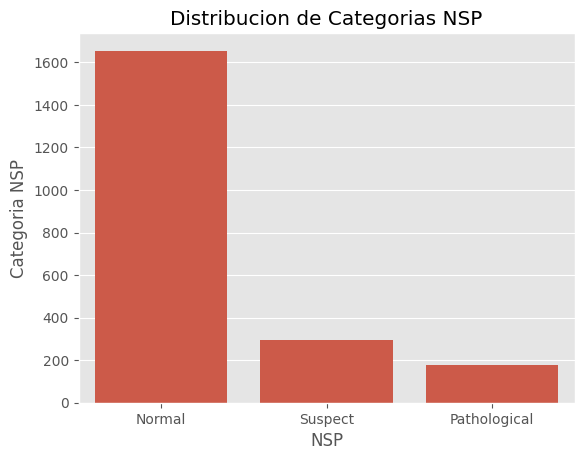

In [21]:
###Con el siguiente código se graficará la columna 'NSP' que corresponde a la clasificación por Estado del Feto
plt.figure()
data_chart = data_corr.copy()
data_chart['NSP'] = data['NSP'].replace({1: 'Normal', 2:'Suspect', 3:'Pathological'})
ax = sns.countplot(data=data_chart, x="NSP", order=["Normal", "Suspect", "Pathological"])
ax.set_title('Distribucion de Categorias NSP')
ax.set_ylabel('Casos')
ax.set_ylabel('Categoria NSP')
plt.show()

Para éste caso, vemos que la gran mayoría de los casos corresponden al estado Normal, por encima de los 1600, contra apenas cerca a 200 casos Patológicos y alrededor de 300 Sospechosos. De nuevo, cómo ser relacionan éstos resultados con los datos.

A continuación crearemos una matriz de correlación para intentar discernir cada relación.

<Axes: >

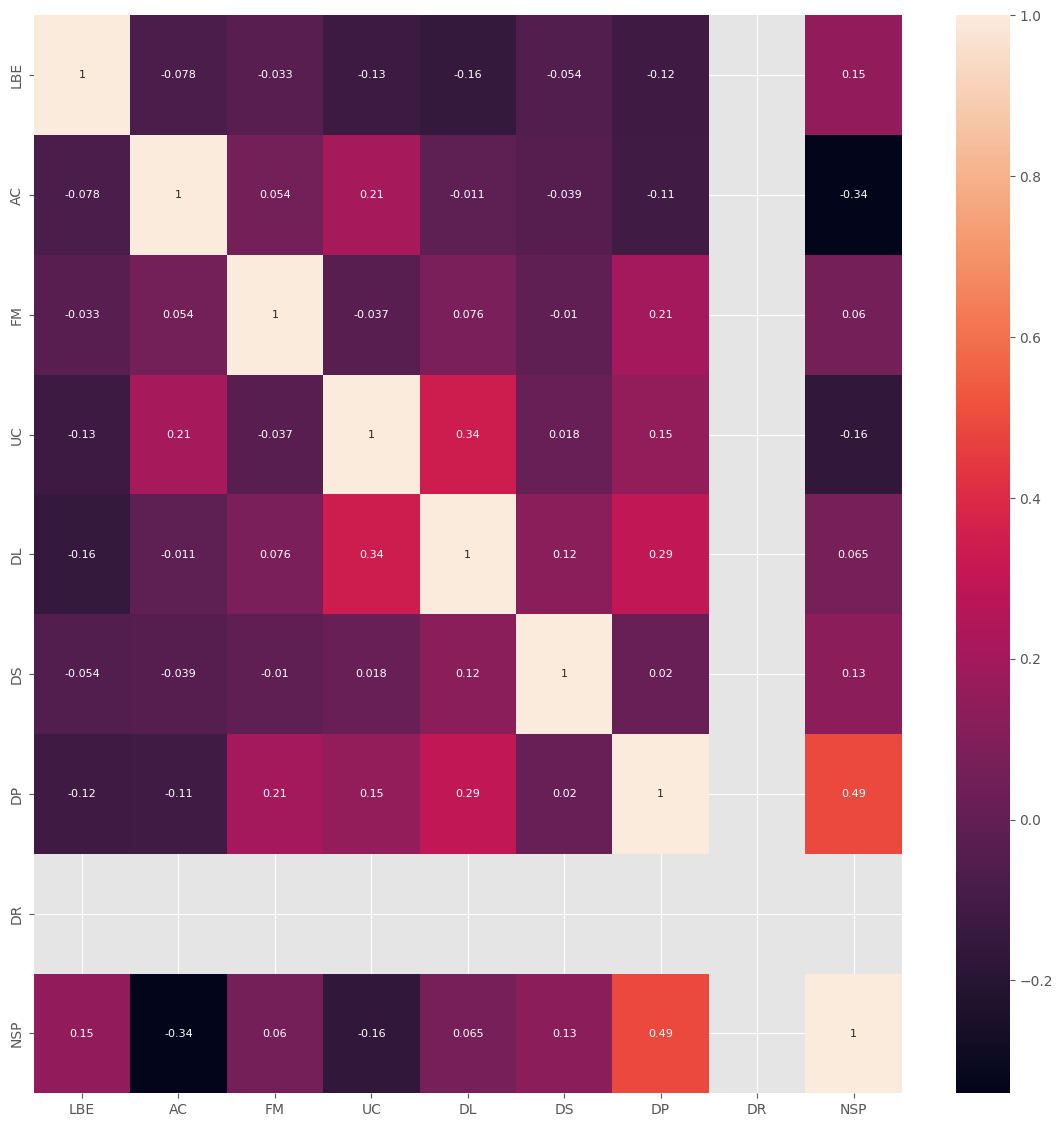

In [22]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data_corr.corr(), annot=True, annot_kws={"size": 8})

In [23]:
#Como correlaciona con NSP

data_corr.corr()['NSP'].sort_values(ascending=False)

NSP    1.000000
DP     0.490626
LBE    0.148151
DS     0.131934
DL     0.065328
FM     0.060366
UC    -0.163295
AC    -0.340394
DR          NaN
Name: NSP, dtype: float64

En éste caso:
- DP: Desaceleraciones Prolongadas como la principal variable correlacionada, con 0.49 tenemos.
- AC: Aceleraciones, con -0.34.
- UC: Contracciones uterinas, con -0.16.
- LBE: Frecuencia Cardiaca con 0.148.

Es interesante que ambas clases posean en común las siguientes variables:

- *DP: desaceleraciones prolongadas (primera en NSP, segunda en CLASS)
- *AC: aceleraciones (segunda en NSP, tercera en CLASS)
- *LBE: valor base Frecuencia Cardiaca (cuarta en ambas)

Para las clases morfológicas la primera es
- *DL: desaceleraciones leves

Para el Estado del Feto, la tercera es
- *UC: contracciones uterinas

Y DR vuelve a aportar nada.

| Morfológicas | Estado Feto |
| ------------ | ------------ |
| ![CLASS](Imagenes/class001.png) | ![Estado Feto](Imagenes/class002.png) |


Definitamente se requiere de un criterio técnico para evaluar si dichas correlaciones hacen sentido en el contexto de una cardiotocografía, de acuerdo a la Guía de monitorización fetal intraparto basada en fisiopatología, tenemos las siguientes definiciones:

DP: Desaceleraciones prolongadas: Aquellas que duran más de 3 minutos. podrían inndicar hipoxia (disminución de oxígeno en un tejido). Las que superen los 5 minutos con una Frecuencia Cardiaca Fetal de menos de 80lpm (latidos por minuto), están frecuentemente asociados con hipoxia/acidosis fetal aguda y requieren una intervención urgente.

AC: Aceleraciones: Es un incremento abrupto de la Frecuencia Cardiaca Fetal, pueden denotar estado de vigilia (desvelo) en el feto. La precencia de aceleraciones suele considerarse un signo tranquilizador, la ausencia por otro lado es un signo, entre otros, de Hipoxia crónica.

LBE: Frecuencia Cardiaca Fetal: un valor normal está entre 110 y 160 latidos por minuto, por encima de 160 lpm durante más de 10min es considerado Taquicardia, por debajo de 110lpm durante más de 10min es considerado Bradicardia.

DL: Desaceleraciones Leves: Son un descenso de la Frecuencia Cardiaca Fetal por debajo de la línea basal de más de 15lpm y que dura más de 15 segundos. Se consideran que son una respouesta refleja para disminuir el gasto cardiaco cuando el feto es expuesto a un estrés hipóxico o mecánico. Estas son un tipo de desaceleración tardía, igualmente relacionada con hipoxia.

UC: Contracciones Uterinas: una frecuencia excesiva, 5 contracciones en 10 minutos se le llama Taquisistolia y la hiperestimulación es debida a una respuesta exagerada a estimulantes uterinos.



## Acciones a seguir:

Para nuestros efectos, aunque hemos determinado cierto nivel de correlación entre algunas variables y las clases exitentes, también encontramos que a excepción de la frecuencia cardiaca fetal, el resto de las variables poseen anomalías, por ende, y cómo sabemos que dichas anomalías podrían estar impactando negativamente dichas correlaciones, necesitamos corregirlos.

Entre los dos grupos iniciaremos con el análisis para el estado fetal NSP.

Acá las columnas a ser analizadas ['LBE', 'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR'] a fin de determinar ['NSP'].



## Tratamiento de los Datos. Detección de Anomalías



In [103]:
#Confirmando que datos existen en esta copia
data_corr.columns

Index(['LBE', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'NSP'], dtype='object')

In [104]:
data_corr.info

<bound method DataFrame.info of         LBE   AC   FM   UC   DL   DS   DP   DR  NSP
0     120.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
1     132.0  4.0  0.0  4.0  2.0  0.0  0.0  0.0  1.0
2     133.0  2.0  0.0  5.0  2.0  0.0  0.0  0.0  1.0
3     134.0  2.0  0.0  6.0  2.0  0.0  0.0  0.0  1.0
4     132.0  4.0  0.0  5.0  0.0  0.0  0.0  0.0  1.0
...     ...  ...  ...  ...  ...  ...  ...  ...  ...
2121  140.0  0.0  0.0  6.0  0.0  0.0  0.0  0.0  2.0
2122  140.0  1.0  0.0  9.0  0.0  0.0  0.0  0.0  2.0
2123  140.0  1.0  0.0  7.0  0.0  0.0  0.0  0.0  2.0
2124  140.0  1.0  0.0  9.0  0.0  0.0  0.0  0.0  2.0
2125  142.0  1.0  1.0  5.0  0.0  0.0  0.0  0.0  1.0

[2126 rows x 9 columns]>

Como ya sabemos que los datos no siguen una distribución normal (excepto LBE o LB), aplicaremos un método estadístico llamado Rango Intercuantil (IQR), con ello, encontraremos los puntos anómalos que sean menores al primer cuartil menos 1.5 veces el IQR y que sean mayores al tercer cuartil mas 1.5 veces el IQR, donde IQR es la diferencia entre los cuatiles tres y uno. Veamos a continuación.

In [68]:
#Función que Calcula el IQR
def find_outliers_IQR(data_corr):
    q1 = data_corr.quantile(0.25)
    q3 = data_corr.quantile(0.75)
    IQR = q3 - q1
    outliers = data_corr[((data_corr < (q1 - 1.5 * IQR)) | (data_corr > (q3 + 1.5 * IQR)))]
    return outliers

In [69]:
#Función para visualizar los resultados de los cálculos
def print_outlier_stats(colOut):
    for column in colOut:
        outliers = find_outliers_IQR(data_corr[column])
        print(f"Columna: {column}")
        print("Número de outliers:", len(outliers))
        if not outliers.empty:
            print("Máximo valor outlier:", outliers.max())
            print("Mínimo valor outlier:", outliers.min())
        print("\n")

In [70]:
#Pasamos solo las columnas que queremos investigar
colOut = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR']
print_outlier_stats(colOut)

Columna: AC
Número de outliers: 83
Máximo valor outlier: 26.0
Mínimo valor outlier: 11.0


Columna: FM
Número de outliers: 310
Máximo valor outlier: 564.0
Mínimo valor outlier: 6.0


Columna: UC
Número de outliers: 22
Máximo valor outlier: 23.0
Mínimo valor outlier: 12.0


Columna: DL
Número de outliers: 81
Máximo valor outlier: 16.0
Mínimo valor outlier: 8.0


Columna: DS
Número de outliers: 7
Máximo valor outlier: 1.0
Mínimo valor outlier: 1.0


Columna: DP
Número de outliers: 178
Máximo valor outlier: 4.0
Mínimo valor outlier: 1.0


Columna: DR
Número de outliers: 0




De los resultados anteriores es necesario hacer ciertas salvedades:

- Como se esperaba LBE no posee anomalías, al menos con éste método, ya que si sigue una distribución normal.
- NSP es una clase y no una variable, lo que se ve en los resultados es realmente el efecto de las frecuencias, por lo que no lo tomaremos en cuenta.

En cuanto a los demás, definitivamente DR no posee datos significativos, por lo que será eliminada del estudio.

Para el resto, haremos dos cosas, el total de datos por variable es del 2126 datos, la que mas anomalías presenta es FM con 310, lo que representa un 14.5% del total, con ese valor, vamos a probar hacerle drop a los datos, para ello, reescribiremos los datos anómalos como NaN y luego eliminamos las filas con ellos.


In [105]:
#ELiminamos DR del análisis.
data_corr = data_corr.drop(columns='DR')

In [106]:
#Función que detecta outliers y los cambia por un valor NaN
#Se pasan solo las columnas que se deben inspeccionar
def mask_outliers_IQR(data_corr, columns=None, inspect=True):
    if columns is None:
        columns = data_corr.columns  # Si no se especifican columnas, se inspeccionan todas
    
    outliers_df = data_corr.copy()  # Copiamos el DataFrame original para no modificarlo directamente
    
    for column in columns:
        if inspect:
            q1 = data_corr[column].quantile(0.25)
            q3 = data_corr[column].quantile(0.75)
            IQR = q3 - q1
            
            outliers_mask = ((data_corr[column] < (q1 - 1.5 * IQR)) | (data_corr[column] > (q3 + 1.5 * IQR)))
            outliers_df.loc[outliers_mask, column] = np.nan  # Reemplazamos los outliers con NaN en el nuevo DataFrame
        else:
            # Si se especifica ignorar, simplemente dejamos la columna intacta
            pass
    
    return outliers_df


In [108]:
columns_to_inspect = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP']
outliers_df = mask_outliers_IQR(data_corr, columns=columns_to_inspect, inspect=True)

# outliers_df ahora contendrá tu DataFrame original con los outliers reemplazados por NaN en las columnas especificadas

In [109]:
#Confirmando que mantenemos el DataFrame original
data_corr.info

<bound method DataFrame.info of         LBE   AC   FM   UC   DL   DS   DP  NSP
0     120.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
1     132.0  4.0  0.0  4.0  2.0  0.0  0.0  1.0
2     133.0  2.0  0.0  5.0  2.0  0.0  0.0  1.0
3     134.0  2.0  0.0  6.0  2.0  0.0  0.0  1.0
4     132.0  4.0  0.0  5.0  0.0  0.0  0.0  1.0
...     ...  ...  ...  ...  ...  ...  ...  ...
2121  140.0  0.0  0.0  6.0  0.0  0.0  0.0  2.0
2122  140.0  1.0  0.0  9.0  0.0  0.0  0.0  2.0
2123  140.0  1.0  0.0  7.0  0.0  0.0  0.0  2.0
2124  140.0  1.0  0.0  9.0  0.0  0.0  0.0  2.0
2125  142.0  1.0  1.0  5.0  0.0  0.0  0.0  1.0

[2126 rows x 8 columns]>

In [110]:
#Nuevo DataFrame con TODOS las anomalías NaN
outliers_df.info

<bound method DataFrame.info of         LBE   AC   FM   UC   DL   DS   DP  NSP
0     120.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
1     132.0  4.0  0.0  4.0  2.0  0.0  0.0  1.0
2     133.0  2.0  0.0  5.0  2.0  0.0  0.0  1.0
3     134.0  2.0  0.0  6.0  2.0  0.0  0.0  1.0
4     132.0  4.0  0.0  5.0  0.0  0.0  0.0  1.0
...     ...  ...  ...  ...  ...  ...  ...  ...
2121  140.0  0.0  0.0  6.0  0.0  0.0  0.0  2.0
2122  140.0  1.0  0.0  9.0  0.0  0.0  0.0  2.0
2123  140.0  1.0  0.0  7.0  0.0  0.0  0.0  2.0
2124  140.0  1.0  0.0  9.0  0.0  0.0  0.0  2.0
2125  142.0  1.0  1.0  5.0  0.0  0.0  0.0  1.0

[2126 rows x 8 columns]>

En éste momento mantenemos la misma cantidad de filas por columna 2126, si contamos la cantidad de NaN corresponderá a la cantidad de anomalías por cada columna.

In [111]:
#Cantidad de anomalías por Variable
outliers_df.isnull().sum()

LBE      0
AC      83
FM     310
UC      22
DL      81
DS       7
DP     178
NSP      0
dtype: int64

In [112]:
# Eliminar filas con valores NaN
outliers_df = outliers_df.dropna()


In [113]:
outliers_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,1558.0,134.037869,10.204800,106.0,126.0,134.0,142.0,160.0
AC,1558.0,2.227214,2.756153,0.0,0.0,1.0,4.0,10.0
FM,1558.0,0.584082,1.189357,0.0,0.0,0.0,1.0,5.0
UC,1558.0,3.519897,2.615954,0.0,1.0,3.0,5.0,11.0
DL,1558.0,1.087291,1.828576,0.0,0.0,0.0,1.0,7.0
DS,1558.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
DP,1558.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
NSP,1558.0,1.221438,0.498298,1.0,1.0,1.0,1.0,3.0


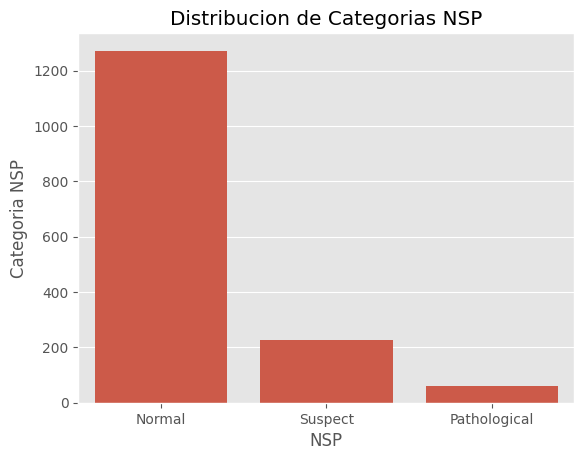

In [114]:
###Con el siguiente código se graficará la columna 'NSP' que corresponde a la clasificación por Estado del Feto
plt.figure()
data_chart = outliers_df.copy()
data_chart['NSP'] = data['NSP'].replace({1: 'Normal', 2:'Suspect', 3:'Pathological'})
ax = sns.countplot(data=data_chart, x="NSP", order=["Normal", "Suspect", "Pathological"])
ax.set_title('Distribucion de Categorias NSP')
ax.set_ylabel('Casos')
ax.set_ylabel('Categoria NSP')
plt.show()

<Axes: >

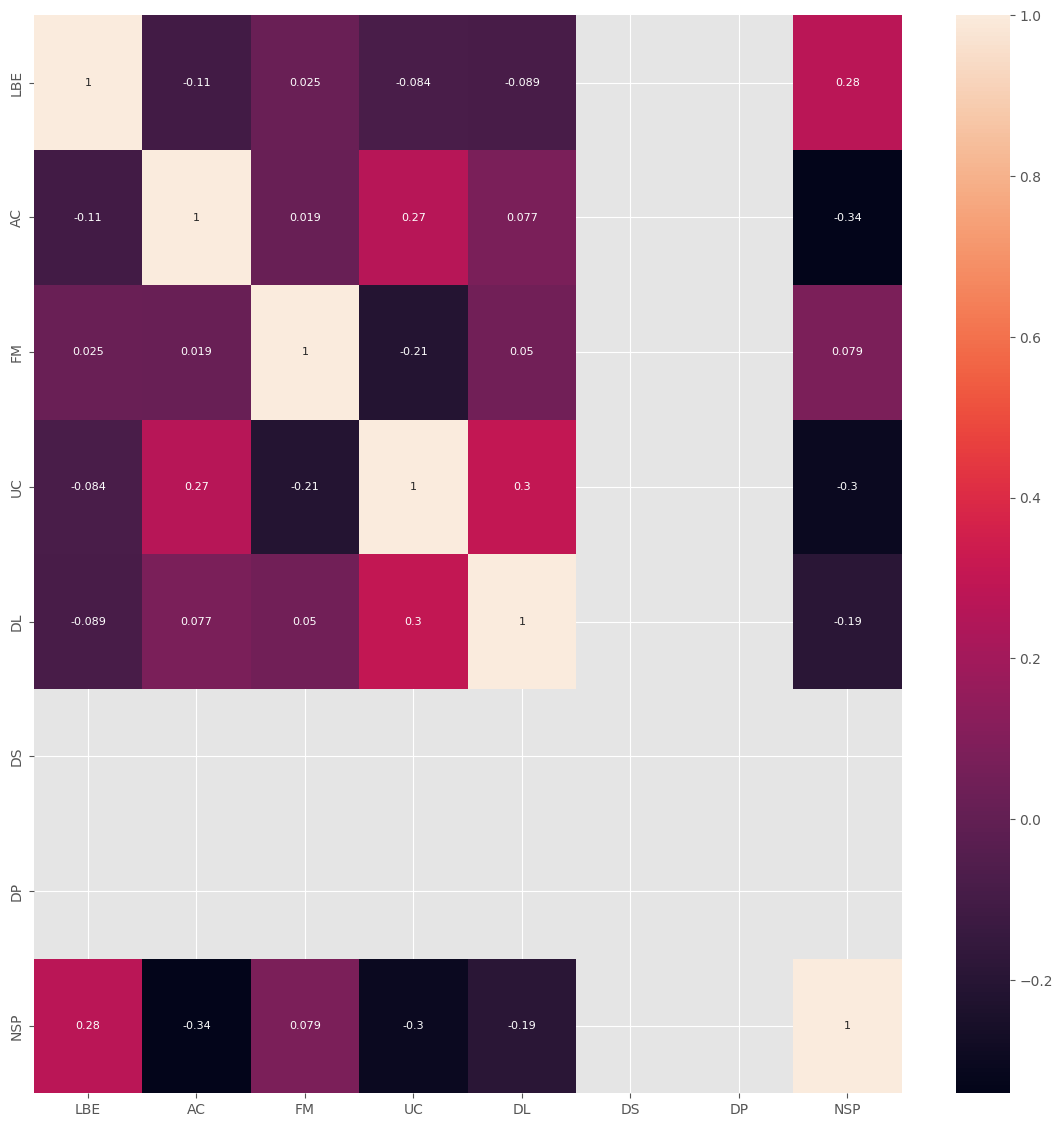

In [115]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(outliers_df.corr(), annot=True, annot_kws={"size": 8})

In [116]:
#Como correlaciona con NSP

outliers_df.corr()['NSP'].sort_values(ascending=False)

NSP    1.000000
LBE    0.276851
FM     0.078559
DL    -0.189692
UC    -0.300241
AC    -0.341097
DS          NaN
DP          NaN
Name: NSP, dtype: float64

Si repetimos lo mismo pero en vez de eliminarlos los imputamos con la media.

In [117]:
def mean_outliers_IQR(data_corr, columns=None, inspect=True):
    if columns is None:
        columns = data_corr.columns  # Si no se especifican columnas, se inspeccionan todas
    
    outliers_df = data_corr.copy()  # Copiamos el DataFrame original para no modificarlo directamente
    
    for column in columns:
        if inspect:
            q1 = data_corr[column].quantile(0.25)
            q3 = data_corr[column].quantile(0.75)
            IQR = q3 - q1
            
            lower_bound = q1 - 1.5 * IQR
            upper_bound = q3 + 1.5 * IQR
            
            # Reemplazar los outliers con la media de la columna
            outliers_df[column] = np.where((data_corr[column] < lower_bound) | (data_corr[column] > upper_bound),
                                           data_corr[column].mean(), outliers_df[column])
        else:
            # Si se especifica ignorar, simplemente dejamos la columna intacta
            pass
    
    return outliers_df

In [118]:
columns_to_inspect = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP']
outliers_df = mean_outliers_IQR(data_corr, columns=columns_to_inspect, inspect=True)

# outliers_df ahora contendrá tu DataFrame original con los outliers reemplazados por la media de las columnas especificadas


In [119]:
#Cantidad de anomalías por Variable
outliers_df.isnull().sum()

LBE    0
AC     0
FM     0
UC     0
DL     0
DS     0
DP     0
NSP    0
dtype: int64

In [120]:
outliers_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.000000
AC,2126.0,2.294434,2.743893,0.0,0.0,1.0,4.0,10.000000
FM,2126.0,1.573755,2.583095,0.0,0.0,0.0,2.0,7.241298
UC,2126.0,3.557158,2.647940,0.0,1.0,3.0,5.0,11.000000
DL,2126.0,1.269133,1.916901,0.0,0.0,0.0,2.0,7.000000
DS,2126.0,0.000011,0.000189,0.0,0.0,0.0,0.0,0.003293
DP,2126.0,0.010554,0.034923,0.0,0.0,0.0,0.0,0.126058
NSP,2126.0,1.304327,0.614377,1.0,1.0,1.0,1.0,3.000000


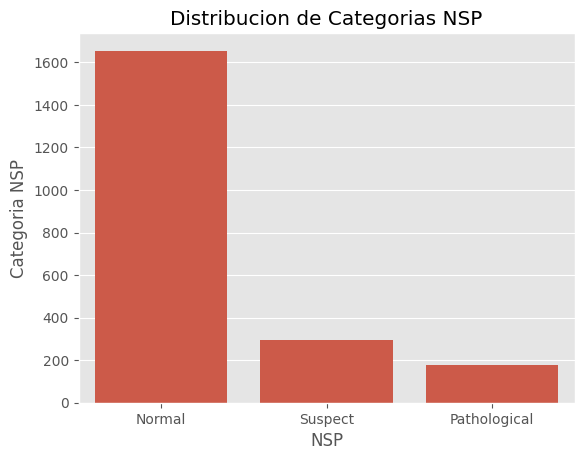

In [121]:
###Con el siguiente código se graficará la columna 'NSP' que corresponde a la clasificación por Estado del Feto
plt.figure()
data_chart = outliers_df.copy()
data_chart['NSP'] = data['NSP'].replace({1: 'Normal', 2:'Suspect', 3:'Pathological'})
ax = sns.countplot(data=data_chart, x="NSP", order=["Normal", "Suspect", "Pathological"])
ax.set_title('Distribucion de Categorias NSP')
ax.set_ylabel('Casos')
ax.set_ylabel('Categoria NSP')
plt.show()

<Axes: >

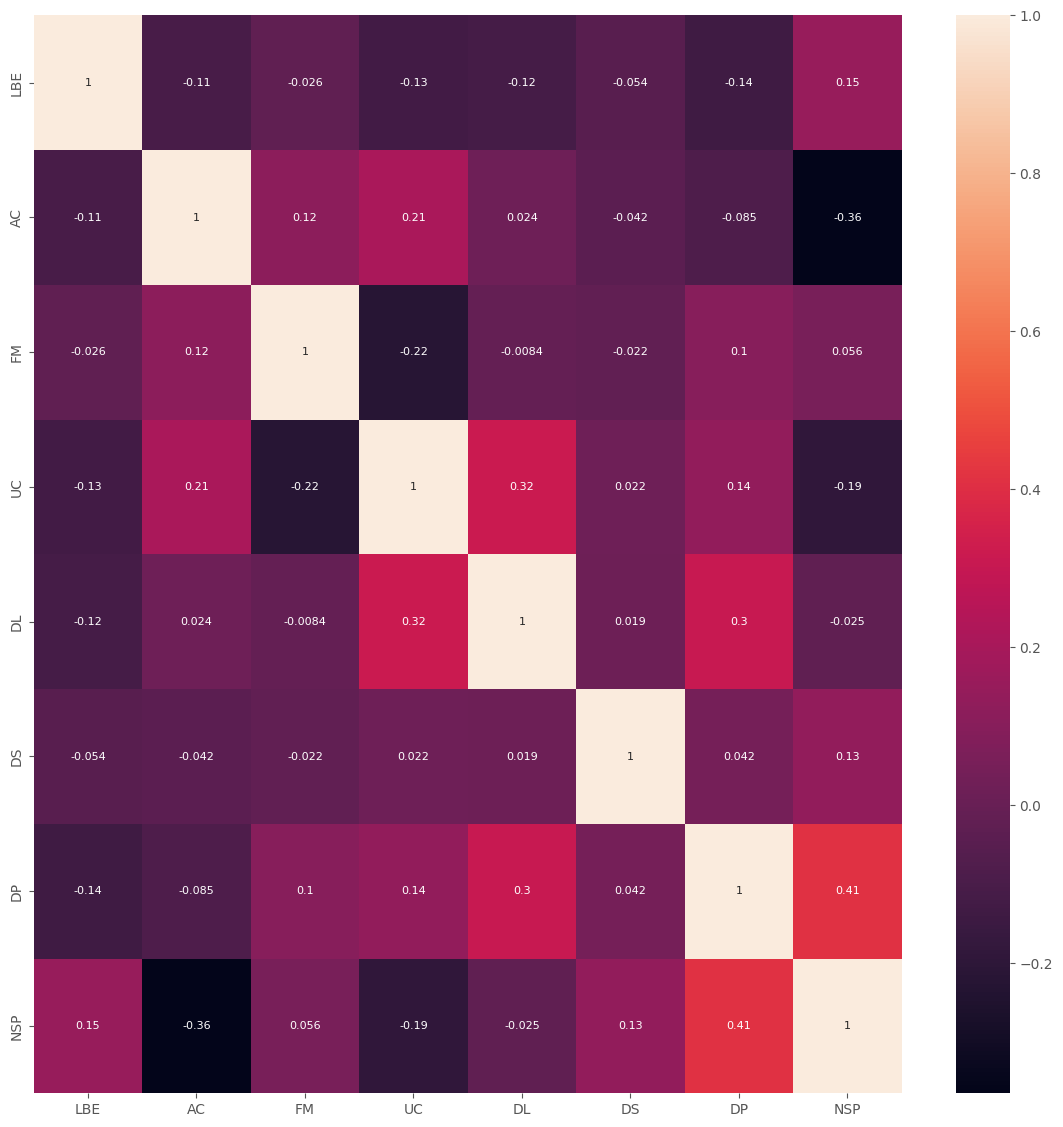

In [122]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(outliers_df.corr(), annot=True, annot_kws={"size": 8})

In [123]:
#Como correlaciona con NSP

outliers_df.corr()['NSP'].sort_values(ascending=False)

NSP    1.000000
DP     0.411484
LBE    0.148151
DS     0.131934
FM     0.056283
DL    -0.025371
UC    -0.193780
AC    -0.364431
Name: NSP, dtype: float64

## Análisis Bivariado

La matriz de correlaciones claramente muestra que hay un par de variables que estan altamente correlacionadas con nuestra variable objetivo NSP: 

Hagamos un analysis bivariado para entender el comportamiento

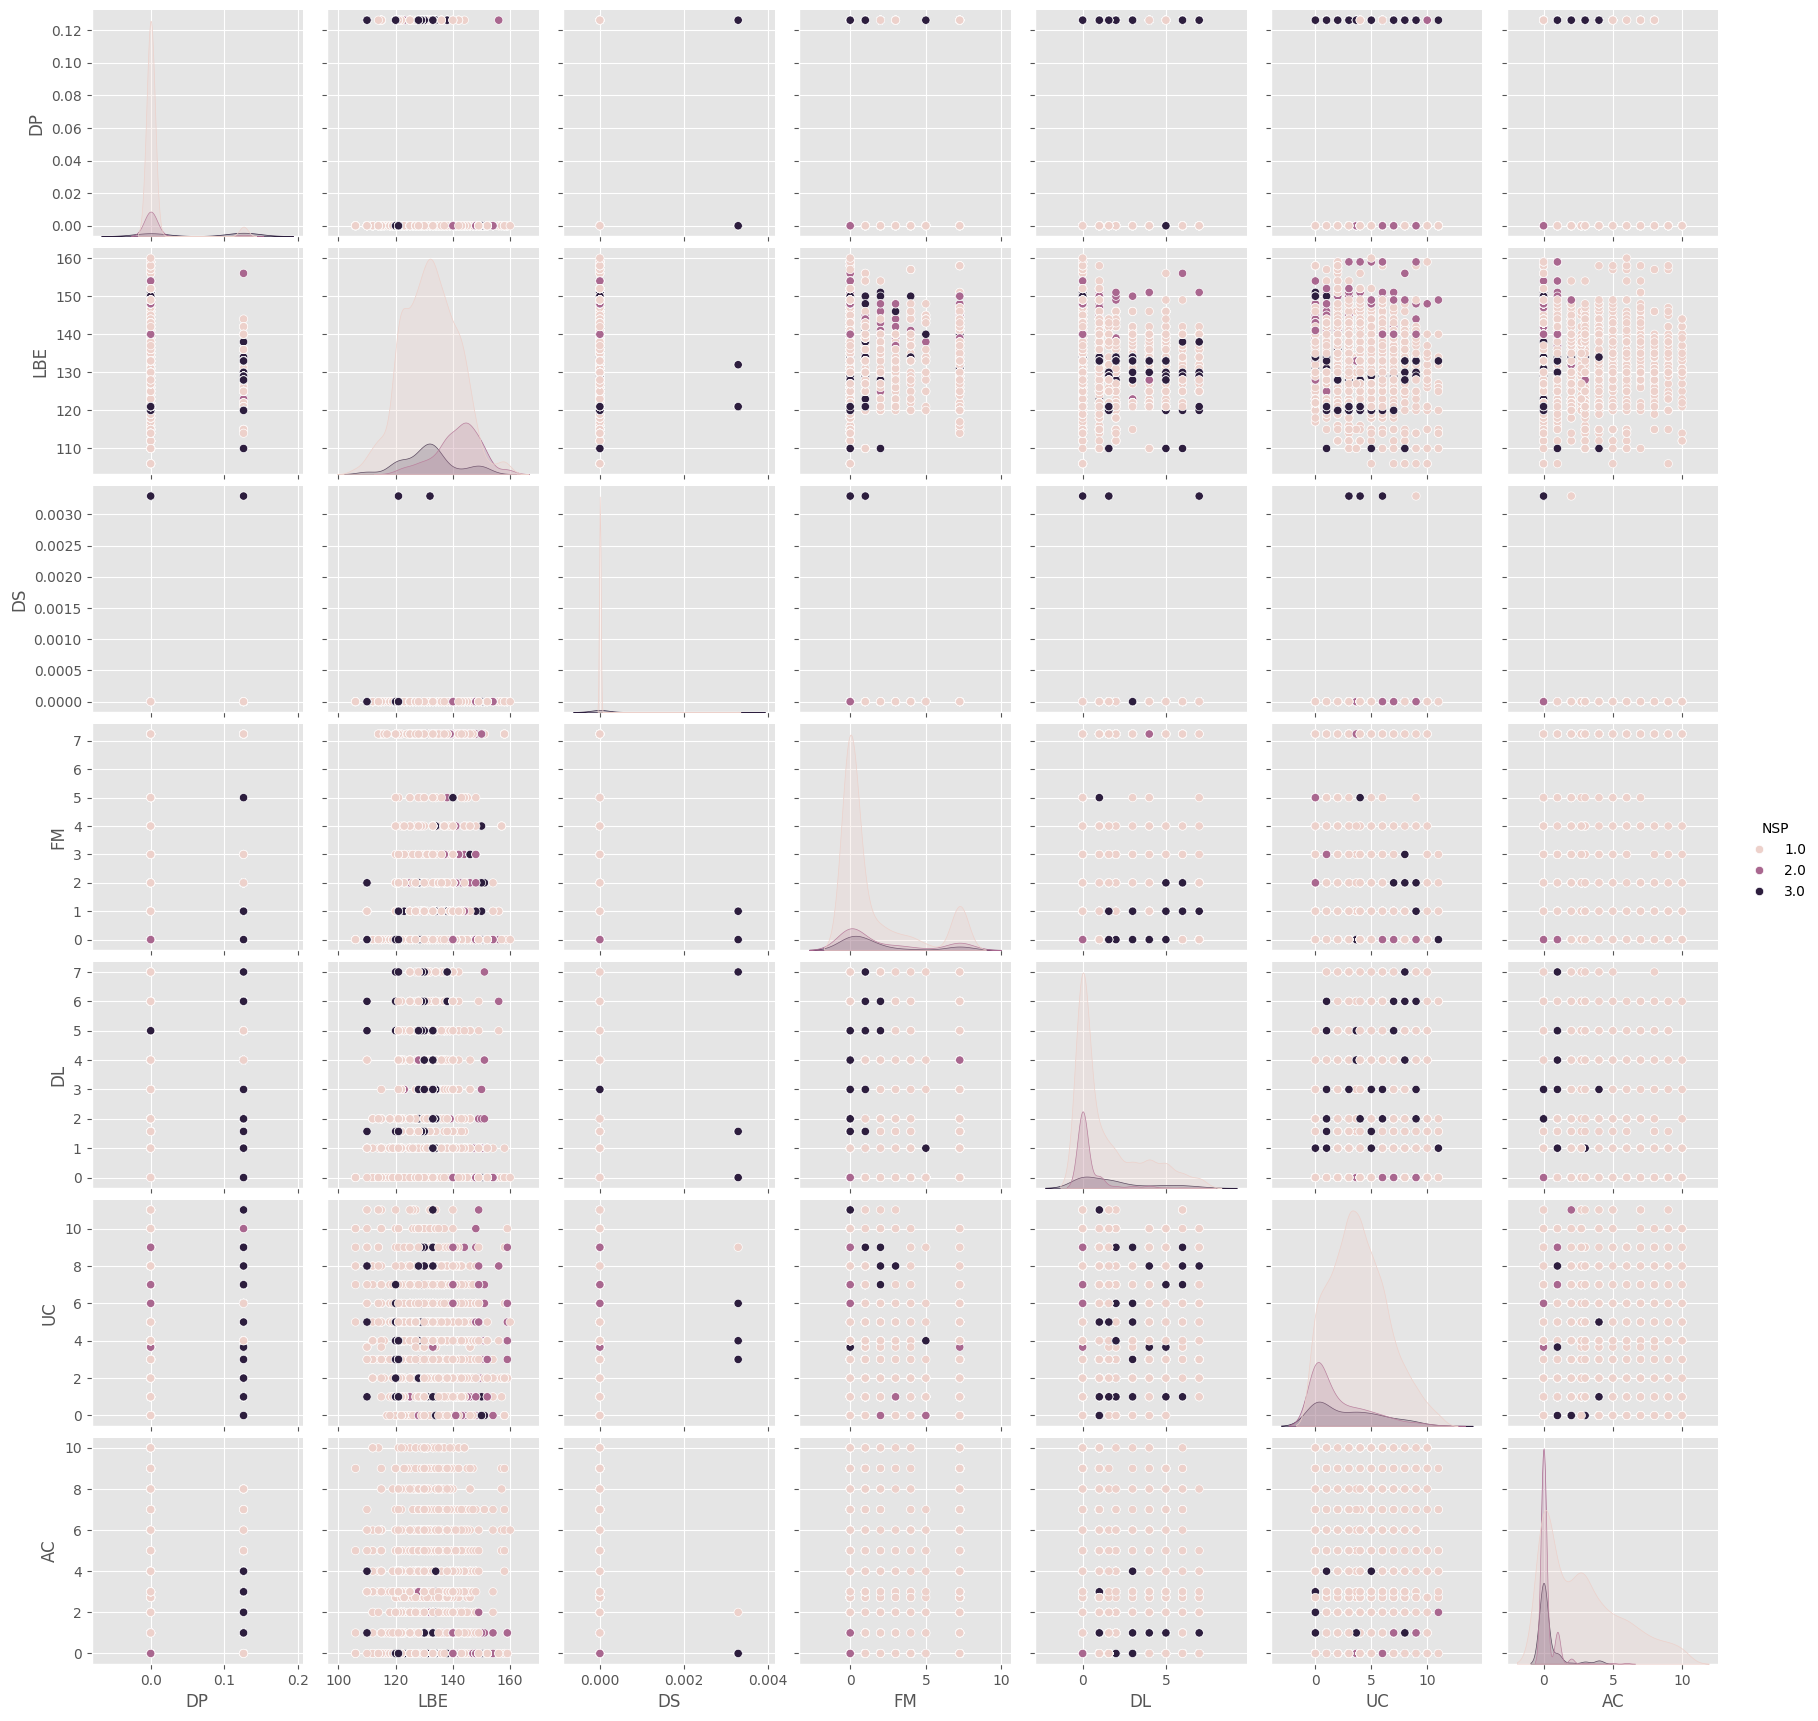

In [126]:
data_chart_vibar = outliers_df[['DP', 'LBE', 'DS', 'FM', 'DL', 'UC', 'AC', 'NSP']]
sns.pairplot(data_chart_vibar, hue='NSP')

## Agrupación y modelado

Primero hacemos el split de entrenamiento y validacion. Aplicaremos scaling al data set. Esto nos ayuda a reducir el efecto de outliers, tambien.

# En la siguiente linea de código cambiar la base de datos

In [132]:
#Cambiar acá si se desea repetir el análisis con otra base de datos.
data_non = outliers_df

<Axes: xlabel='Score', ylabel='Feature'>

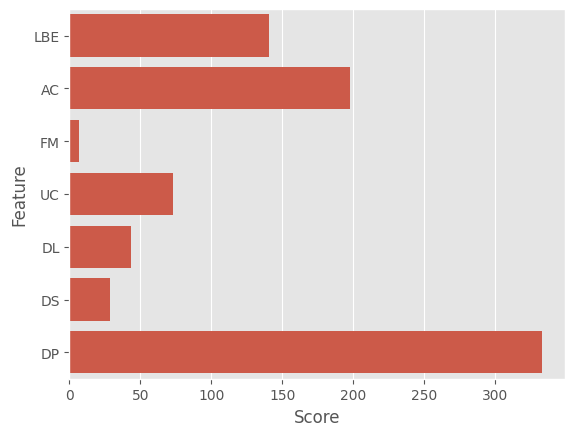

In [128]:
#data_non = data.dropna()
X=data_non.drop('NSP', axis=1)
Y=data_non['NSP']

best = SelectKBest(score_func=f_classif, k='all')
fit = best.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
features = pd.concat([dfcolumns, dfscores], axis=1)
features.columns = ['Feature', 'Score']

sns.barplot(data=features, x='Score', y='Feature', orient='h')


Los resultados de este feature selection confirman lo que habiamos visto anteriormente, los features que principalmente comparten informacion son: LD, FS, DP, ASTV, ALTV, Mode, Mean, Median, E.
Seleccionaremos a todo lo que sea mayor a 200


In [129]:
feat_select = features[features['Score'] >= 200]
feat_select = list(feat_select['Feature'])
feat_select.append('NSP')
model_data = data_non[feat_select]
model_data

,DP,NSP
0,0.0,2.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
2121,0.0,2.0
2122,0.0,2.0
2123,0.0,2.0
2124,0.0,2.0


In [130]:
#Splitting
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(model_data.drop(['NSP'], axis=1), model_data['NSP'],test_size=0.25, random_state=2978,
                                                 stratify=model_data['NSP'])

#Scaling

scaler=preprocessing.StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test) 


In [131]:
#A quick model selection process
#pipelines of models( it is short was to fit and pred)
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=2978))])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=2978))])

# pipeline_xgb = Pipeline([('xgb_classifier', XGBClassifier(random_state=2978))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier())])

pipeline_svc=Pipeline([('sv_classifier',SVC())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'LogisticR', 1: 'DecTree', 2: "RandomForest", 3:"SVC"}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train_scaled, y_train)

#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LogisticR: 0.778550 
DecTree: 0.790476 
RandomForest: 0.790476 
SVC: 0.790476 


## Referencias

- [1] XGBoost Documentation. (s.f.). XGBoost Documentation. Recuperado de https://xgboost.readthedocs.io/en/stable/
- [2] CUN. (s.f.). Diccionario Médico. Recuperado de https://www.cun.es/diccionario-medico/terminos/cardiotocografia
- [3] SISPORTO. (s.f.). A Brief History of the SISPORTO Project. Recuperado de https://sisporto.med.up.pt/a-brief-history-of-the-sisporto-project/


